In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load

In [120]:
def move_column_after(df, col, destination):
    cols = df.columns.tolist()
    cols.remove(col)
    cols.insert(cols.index(destination) + 1, col )
    return df[cols]

def override_columns(stats: pd.DataFrame):
    def column_div(lhs, rhs):
        return np.where(rhs != 0, lhs / rhs, 0)

    stats["referenced non-empty / referenced"] = column_div(stats["referenced non-empty"], stats["referenced"])
    stats["read non-empty / referenced"] = column_div(stats["read non-empty"], stats["referenced"])
    stats["used / referenced"] = column_div(stats["used"], stats["referenced"])

    stats["optimized away non-empty / unused non-empty"] = column_div(stats["optimized away non-empty"], stats["unused non-empty"])
    stats["dependent / unused non-empty"] = column_div(stats["dependent"], stats["unused non-empty"])
    stats["other unused non-empty / unused non-empty"] = column_div(stats["other reasons unused non-empty"], stats["unused non-empty"])

    stats["polluted / referenced non-empty"] = column_div(stats["polluted"], stats["referenced non-empty"])
    stats["used polluted / used"] = column_div(stats["used polluted"], stats["used"])
    stats["used polluted / polluted"] = column_div(stats["used polluted"], stats["polluted"])

    return stats

def load_stats(filename, totals = False):
    stats = pd.read_csv(filename)

    # Split to name and set
    stats[["set", "name"]] = stats["name"].str.split(":", expand=True)
    stats = move_column_after(stats, "set", "name")

    # Set index, sort
    stats.sort_values(by=["set", "name"], inplace=True, key=lambda x: x.str.lower())
    stats.set_index("name", inplace=True)

    # Move titanic to the end
    if "titanic" in stats.index:
        stats = pd.concat([stats.drop("titanic"), stats.loc[["titanic"]]])

    if totals:
        stats = override_columns(stats)

    return stats

def load_all_stats(filename, totals = False):
    stats = pd.read_csv(filename)

    # Set index, sort
    stats.index = stats["benchmark"].astype(str) + ":" + stats["closure"].astype(str)
    stats.sort_index(inplace=True)

    if totals:
        stats = override_columns(stats)

    return stats

# Plot

In [121]:
def plot(df: pd.DataFrame, index, columns,
         title = None,
         figsize= (15, 5), colors = None,
         labels = None, legend = None,
         xlabel = None, ylabel = None):
    df = df.copy()
    df.index = index

    ax = df[columns].plot(
        kind="bar",
        figsize=figsize,
        color=colors
    )

    if labels == "values":
        labels = [df[col].round(2) for col in columns]

    if labels is not None:
        for container, l in zip(ax.containers, labels):
            ax.bar_label(container, labels=l, label_type="edge", padding=2)

    if legend is not None:
        plt.legend(legend, loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=len(df.columns))

    if title is not None:
        plt.title(title)

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)

    plt.savefig("./figures/" + title + ".pdf", bbox_inches='tight')
    plt.show()

In [122]:
def plot_aggregate(df, total = False, **kwargs):
    index = df.index + "\n(" + df["referenced"].astype(str) + " referenced slots)"

    plot(
        df,

        index = index,
        columns = [
            "referenced non-empty / referenced",
            "read non-empty / referenced",
            "used / referenced"
        ],

        title= "Usage of slots across closure compilations",

        colors=["tab:blue", "orange", "tab:red"],

        labels = [
            df["referenced non-empty"],
            df["read non-empty"],
            df["used"]
        ] if total else "values",

        legend=[
            "% of non-empty slots (referenced non-empty / referenced)",
            "% of read non-empty slots (read non-empty / referenced)",
            "% of used non-empty slots (used non-empty / referenced)"
        ],

        ylabel="Percentage out of referenced",

        **kwargs
    )

def plot_all(df, title, **kwargs):
    plot(
        df,
        index = df["referenced"],
        columns = [
            "referenced non-empty / referenced",
            "read non-empty / referenced",
            "used / referenced"
        ],

        title=title,

        figsize=(len(df) / 2, 5),
        colors=["tab:blue", "orange", "tab:red"],

        legend=[
            "% of non-empty slots (referenced non-empty / referenced)",
            "% of read non-empty slots (read non-empty / referenced)",
            "% of used non-empty slots (used non-empty / referenced)"
        ],

        xlabel="Referenced slots",
        ylabel="Percentage out of referenced",

        **kwargs
    )

def plot_unused(df, totals = False, **kwargs):
    index = df.index + "\n(" + df["unused non-empty"].astype(str) + " unused non-empty slots)"

    plot(df,
        index = index,
        columns=["optimized away non-empty / unused non-empty", "dependent / unused non-empty"],

        title="Unused non-empty slots",

        colors=["tab:green", "tab:brown"],

        labels=[df["optimized away non-empty"], df["dependent"]]
            if totals else "values",
        legend=[
            "% of non-empty slots optimized away (optimized away non-empty / unused non-empty)",
            "% of redundant slots (redundant / unused non-empty)"
        ],

        ylabel="Percentage out of unused non-empty",

        **kwargs
    )

def plot_used(df, **kwargs):
    df = df.copy()
    index = df.index + "\n(" + df["used"].astype(str) + " used slots)"

    cols = ["exact match", "widened", "narrowed"]

    for col in cols:
        df[col + " %"] = df[col] / df["used"]

    plot(df,
        index=index,
        columns=[ col + " %" for col in cols ],

        title="Used slots",

        colors=["cornflowerblue", "tomato", "gold"],

        labels=[ df[col] for col in cols ],
        legend = ["Used as exact match", "Used widened", "Used narrowed"],

        ylabel="Percentage out of used",

        **kwargs
    )

In [123]:
stats = load_stats("results/stats.csv")

# stats_totals = load_stats("results/stats.csv", True)

In [127]:
stats["dependent"].sum()

25066

In [125]:
stats

,set,referenced,referenced non-empty,read non-empty,used,unused non-empty,present non-empty,exact match,widened,narrowed,optimized away non-empty,dependent,other reasons unused non-empty,polluted,used polluted,unused polluted,used polluted exact match,used polluted widened,used polluted narrowed,closure version compilations,closure version compilations using some type feedback,referenced non-empty / referenced,read non-empty / referenced,used / referenced,optimized away non-empty / unused non-empty,dependent / unused non-empty,other reasons unused non-empty / unused non-empty,polluted / referenced non-empty,unused polluted / unused non-empty,used polluted / used,used polluted / polluted,used polluted exact match / exact match,used polluted widened / widened,used polluted narrowed / narrowed,used / referenced non-empty
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bounce_nonames_simple,areWeFast,264,160,117,12,148,77,7,5,0,71,128,9,16,3,13,0,3,0,11,7,0.781433,0.680735,0.172829,0.355792,0.556005,0.327005,0.220293,0.172798,0.333333,0.333333,0.000000,0.750000,0.000000,0.204793
Mandelbrot,areWeFast,358,280,213,24,256,117,14,10,0,139,233,10,19,4,15,0,4,0,14,9,0.843402,0.728668,0.161456,0.344474,0.689372,0.192308,0.209424,0.170797,0.194444,0.218750,0.000000,0.388889,0.000000,0.196470
flexclust_no_s4,RealThing,5338,2499,1818,701,1798,770,521,179,1,1028,1484,148,249,58,191,8,49,1,142,93,0.613403,0.523463,0.156455,0.440934,0.492947,0.320194,0.168597,0.149248,0.208361,0.231735,0.044362,0.353922,1.000000,0.262503
volcano,RealThing,2037,507,465,119,388,155,107,12,0,233,354,17,17,3,14,0,3,0,23,16,0.551936,0.514229,0.169042,0.432315,0.541501,0.316184,0.077867,0.056108,0.093750,0.312500,0.000000,0.250000,0.000000,0.310995
binarytrees/binarytrees_naive,shootout,1070,341,218,83,258,112,56,27,0,146,213,33,72,21,51,4,17,0,22,13,0.565916,0.382067,0.113918,0.532638,0.606639,0.268119,0.205200,0.180770,0.336752,0.322500,0.074592,0.690476,0.000000,0.242096
fannkuch/fannkuchredux,shootout,251,184,165,5,179,64,4,1,0,115,163,8,6,1,5,0,1,0,6,3,0.701663,0.616824,0.082908,0.567955,0.619899,0.176717,0.120922,0.087626,0.333333,0.166667,0.000000,1.000000,0.000000,0.109883
fannkuch/fannkuchredux_naive,shootout,244,164,143,3,161,52,2,1,0,109,145,8,6,1,5,0,1,0,5,2,0.719555,0.611250,0.065091,0.570241,0.524185,0.221241,0.151487,0.109877,0.500000,0.166667,0.000000,1.000000,0.000000,0.066259
fasta/fasta_naive_2,shootout,598,343,251,73,270,111,44,29,0,159,225,19,23,5,18,0,5,0,17,11,0.742709,0.549981,0.126782,0.463718,0.565152,0.272775,0.088382,0.060171,0.164773,0.236607,0.000000,0.247619,0.000000,0.171056
knucleotide/knucleotide,shootout,1493,809,499,148,661,251,89,59,0,410,517,64,71,12,59,0,12,0,59,33,0.711240,0.562396,0.117276,0.537912,0.555019,0.209557,0.108234,0.087246,0.177082,0.223333,0.000000,0.252232,0.000000,0.164559


In [ ]:
stats.sum()

set                                                      areWeFastareWeFastRealThingRealThingshootoutsh...
referenced                                                                                           84641
referenced non-empty                                                                                 41254
read non-empty                                                                                       28572
used                                                                                                  9251
unused non-empty                                                                                     32003
present non-empty                                                                                    14835
exact match                                                                                           6058
widened                                                                                               3181
narrowed                             

In [ ]:
table = stats[["set", "closure version compilations", "closure version compilations using some type feedback", "referenced"]]
display(table)
table.to_latex('table.tex')

,set,closure version compilations,closure version compilations using some type feedback,referenced
name,,,,
Bounce_nonames_simple,areWeFast,11,7,264
Mandelbrot,areWeFast,14,9,358
flexclust_no_s4,RealThing,142,93,5338
volcano,RealThing,23,16,2037
binarytrees/binarytrees_naive,shootout,22,13,1070
fannkuch/fannkuchredux,shootout,6,3,251
fannkuch/fannkuchredux_naive,shootout,5,2,244
fasta/fasta_naive_2,shootout,17,11,598
knucleotide/knucleotide,shootout,59,33,1493


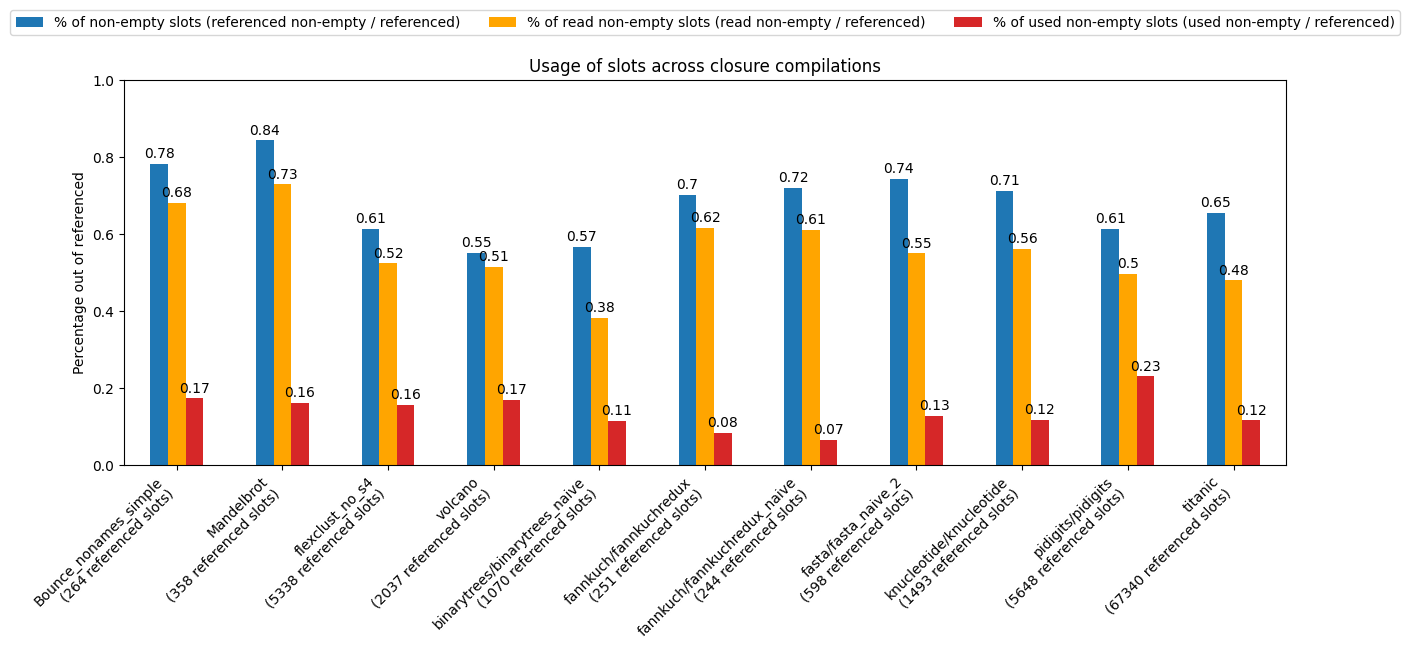

In [ ]:
plot_aggregate(stats)
# plot_aggregate(stats_totals, True)

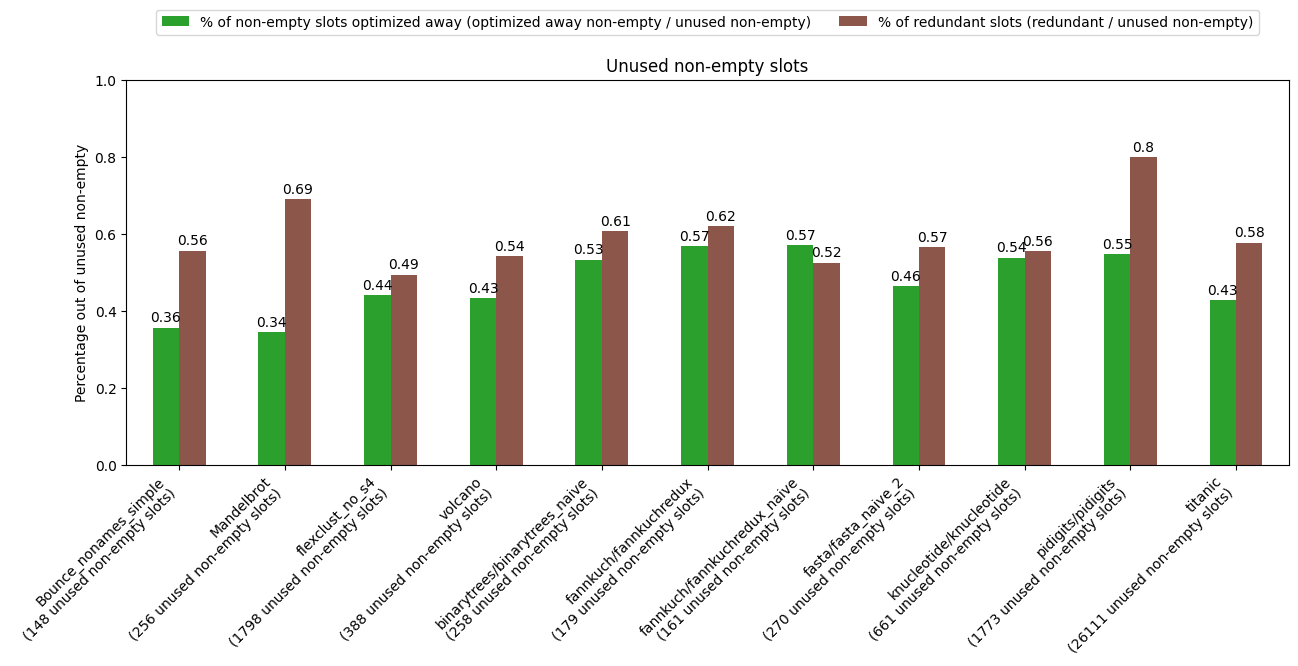

In [ ]:
plot_unused(stats)
# plot_unused(stats_totals, True)

In [ ]:
poll = stats[["closure version compilations", "referenced", "referenced non-empty", "used"] + [ col for col in stats.columns if "polluted" in col ]].copy()
poll.loc["[means]"] = poll.mean()

int_cols = ["closure version compilations", "referenced", "referenced non-empty", "used", "polluted", "used polluted"]
poll[int_cols] = poll[int_cols].astype(int)

display(poll.round(2))

,closure version compilations,referenced,referenced non-empty,used,polluted,used polluted,unused polluted,used polluted exact match,used polluted widened,used polluted narrowed,polluted / referenced non-empty,unused polluted / unused non-empty,used polluted / used,used polluted / polluted,used polluted exact match / exact match,used polluted widened / widened,used polluted narrowed / narrowed
name,,,,,,,,,,,,,,,,,
Bounce_nonames_simple,11,264,160,12,16,3,13.00,0.00,3.00,0.00,0.22,0.17,0.33,0.33,0.00,0.75,0.00
Mandelbrot,14,358,280,24,19,4,15.00,0.00,4.00,0.00,0.21,0.17,0.19,0.22,0.00,0.39,0.00
flexclust_no_s4,142,5338,2499,701,249,58,191.00,8.00,49.00,1.00,0.17,0.15,0.21,0.23,0.04,0.35,1.00
volcano,23,2037,507,119,17,3,14.00,0.00,3.00,0.00,0.08,0.06,0.09,0.31,0.00,0.25,0.00
binarytrees/binarytrees_naive,22,1070,341,83,72,21,51.00,4.00,17.00,0.00,0.21,0.18,0.34,0.32,0.07,0.69,0.00
fannkuch/fannkuchredux,6,251,184,5,6,1,5.00,0.00,1.00,0.00,0.12,0.09,0.33,0.17,0.00,1.00,0.00
fannkuch/fannkuchredux_naive,5,244,164,3,6,1,5.00,0.00,1.00,0.00,0.15,0.11,0.50,0.17,0.00,1.00,0.00
fasta/fasta_naive_2,17,598,343,73,23,5,18.00,0.00,5.00,0.00,0.09,0.06,0.16,0.24,0.00,0.25,0.00
knucleotide/knucleotide,59,1493,809,148,71,12,59.00,0.00,12.00,0.00,0.11,0.09,0.18,0.22,0.00,0.25,0.00


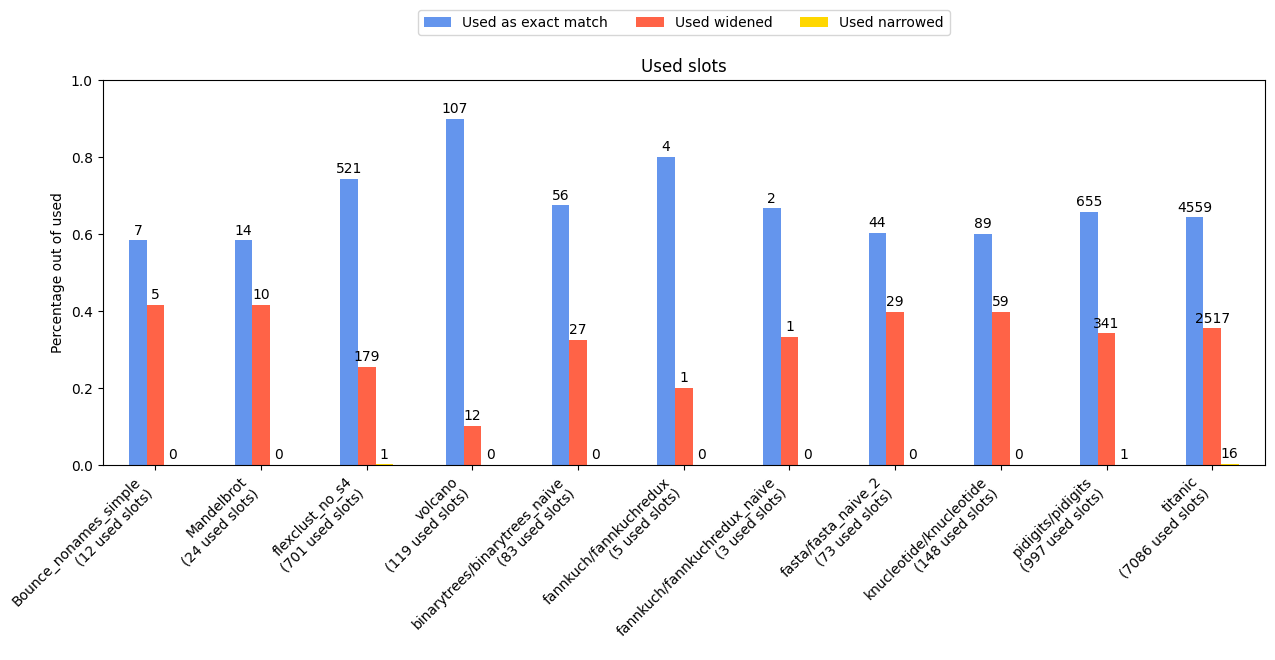

In [ ]:
plot_used(stats)

In [ ]:
stats.columns

Index(['set', 'referenced', 'referenced non-empty', 'read non-empty', 'used',
       'unused non-empty', 'present non-empty', 'exact match', 'widened',
       'narrowed', 'optimized away non-empty', 'dependent',
       'other reasons unused non-empty', 'polluted', 'used polluted',
       'unused polluted', 'used polluted exact match', 'used polluted widened',
       'used polluted narrowed', 'closure version compilations',
       'closure version compilations using some type feedback',
       'referenced non-empty / referenced', 'read non-empty / referenced',
       'used / referenced', 'optimized away non-empty / unused non-empty',
       'dependent / unused non-empty',
       'other reasons unused non-empty / unused non-empty',
       'polluted / referenced non-empty', 'unused polluted / unused non-empty',
       'used polluted / used', 'used polluted / polluted',
       'used polluted exact match / exact match',
       'used polluted widened / widened', 'used polluted narrowed / nar

In [ ]:
stats["% exact match"] = stats["exact match"] / stats["used"]
stats["% narrowed"] = stats["narrowed"] / stats["used"]
stats["% widened"] = stats["widened"] / stats["used"]

stats[[col for col in stats.columns if "/" in col or "%" in col ]].mean()

referenced non-empty / referenced                    0.681775
read non-empty / referenced                          0.558712
used / referenced                                    0.137424
optimized away non-empty / unused non-empty          0.474557
dependent / unused non-empty                         0.593177
other reasons unused non-empty / unused non-empty    0.244616
polluted / referenced non-empty                      0.171592
unused polluted / unused non-empty                   0.147403
used polluted / used                                 0.261800
used polluted / polluted                             0.259330
used polluted exact match / exact match              0.022334
used polluted widened / widened                      0.551710
used polluted narrowed / narrowed                    0.175325
used / referenced non-empty                          0.207520
% exact match                                        0.677714
% narrowed                                           0.000426
% widene

In [ ]:
display((stats["used polluted widened"] / stats["used polluted"]).mean())
(stats["used polluted widened"] / stats["used polluted"])

0.9334598691672493

name
Bounce_nonames_simple            1.000000
Mandelbrot                       1.000000
flexclust_no_s4                  0.844828
volcano                          1.000000
binarytrees/binarytrees_naive    0.809524
fannkuch/fannkuchredux           1.000000
fannkuch/fannkuchredux_naive     1.000000
fasta/fasta_naive_2              1.000000
knucleotide/knucleotide          1.000000
pidigits/pidigits                0.884735
titanic                          0.728972
dtype: float64

name
Bounce_nonames_simple               5
Mandelbrot                         10
flexclust_no_s4                   179
volcano                            12
binarytrees/binarytrees_naive      27
fannkuch/fannkuchredux              1
fannkuch/fannkuchredux_naive        1
fasta/fasta_naive_2                29
knucleotide/knucleotide            59
pidigits/pidigits                 341
titanic                          2517
Name: widened, dtype: int64

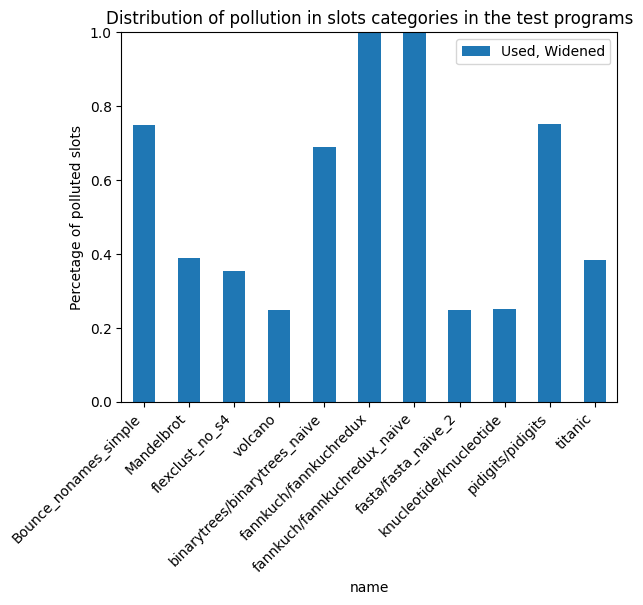

In [ ]:
used_polluted = stats[[
    "used polluted widened / widened",
    #   "used polluted narrowed / narrowed"
]].copy()

display(stats["widened"])
used_polluted.columns = ["Used, Widened"]

# used_polluted.plot.box(showmeans=True)
used_polluted.plot(kind="bar")
plt.ylim(0, 1.0)
plt.ylabel("Percetage of polluted slots")
plt.title("Distribution of pollution in slots categories in the test programs")
plt.xticks(rotation=45, ha='right')
plt.show()

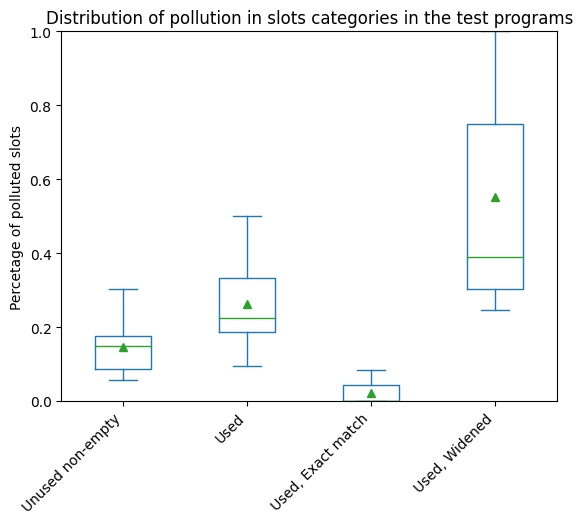

In [ ]:
used_polluted = stats[[
    "unused polluted / unused non-empty",
    "used polluted / used",
    "used polluted exact match / exact match",
    "used polluted widened / widened",
    #   "used polluted narrowed / narrowed"
]].copy()

used_polluted.columns = ["Unused non-empty", "Used", "Used, Exact match", "Used, Widened"]

used_polluted.plot.box(showmeans=True)
plt.ylim(0, 1.0)
plt.ylabel("Percetage of polluted slots")
plt.title("Distribution of pollution in slots categories in the test programs")
plt.xticks(rotation=45, ha='right')
plt.show()